In [1]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, unix_timestamp, to_date
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import year, month
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
spark = SparkSession.builder \
    .appName("BCAStockPricePrediction") \
    .getOrCreate()

In [3]:
df = spark.read.csv(r"C:\Users\ASUS\Documents\proyek machine learning\projek 1\BBCA.JK.csv", header=True, inferSchema=True)
df.show(5)

+----------+------+------+------+------+--------------+--------+
|      Date|  Open|  High|   Low| Close|     Adj Close|  Volume|
+----------+------+------+------+------+--------------+--------+
|2019-01-01|5200.0|5200.0|5200.0|5200.0|4629.853515625|       0|
|2019-01-02|5200.0|5245.0|5200.0|5240.0|    4665.46875|35956000|
|2019-01-03|5200.0|5220.0|5115.0|5180.0|   4612.046875|72358000|
|2019-01-04|5175.0|5205.0|5125.0|5205.0|4634.306640625|51465000|
|2019-01-07|5265.0|5325.0|5245.0|5245.0|4669.919921875|73438000|
+----------+------+------+------+------+--------------+--------+
only showing top 5 rows



In [4]:
df.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: integer (nullable = true)



In [5]:
df.describe().show()

+-------+------------------+------------------+-----------------+------------------+------------------+-------------------+
|summary|              Open|              High|              Low|             Close|         Adj Close|             Volume|
+-------+------------------+------------------+-----------------+------------------+------------------+-------------------+
|  count|              1352|              1352|             1352|              1352|              1352|               1352|
|   mean| 7321.205621301775| 7384.826183431953|7254.038461538462| 7318.786982248521| 6886.348415397328|       8.43182875E7|
| stddev|1414.1274049469944|1419.1198845049746|1412.284556452341|1416.2244196098998|1546.9012793760191|5.623784570037434E7|
|    min|            4450.0|            4800.0|           4325.0|            4430.0| 3992.931396484375|                  0|
|    max|           10400.0|           10400.0|          10150.0|           10325.0|           10100.0|          756431600|
+-------

In [6]:
df = df.withColumn("date", to_date(unix_timestamp(col("date"), "yyyy-MM-dd").cast("timestamp")))
df = df.withColumn("year", year(col("date"))).withColumn("month", month(col("date")))

# Menampilkan beberapa baris data setelah transformasi
df.show(5)

+----------+------+------+------+------+--------------+--------+----+-----+
|      date|  Open|  High|   Low| Close|     Adj Close|  Volume|year|month|
+----------+------+------+------+------+--------------+--------+----+-----+
|2019-01-01|5200.0|5200.0|5200.0|5200.0|4629.853515625|       0|2019|    1|
|2019-01-02|5200.0|5245.0|5200.0|5240.0|    4665.46875|35956000|2019|    1|
|2019-01-03|5200.0|5220.0|5115.0|5180.0|   4612.046875|72358000|2019|    1|
|2019-01-04|5175.0|5205.0|5125.0|5205.0|4634.306640625|51465000|2019|    1|
|2019-01-07|5265.0|5325.0|5245.0|5245.0|4669.919921875|73438000|2019|    1|
+----------+------+------+------+------+--------------+--------+----+-----+
only showing top 5 rows



In [7]:
(trainingData, testData) = df.randomSplit([0.8, 0.2], seed=1234)

In [8]:
trainingData.show(5)

+----------+------+------+------+------+----------------+--------+----+-----+
|      date|  Open|  High|   Low| Close|       Adj Close|  Volume|year|month|
+----------+------+------+------+------+----------------+--------+----+-----+
|2019-01-01|5200.0|5200.0|5200.0|5200.0|  4629.853515625|       0|2019|    1|
|2019-01-03|5200.0|5220.0|5115.0|5180.0|     4612.046875|72358000|2019|    1|
|2019-01-04|5175.0|5205.0|5125.0|5205.0|  4634.306640625|51465000|2019|    1|
|2019-01-08|5230.0|5320.0|5205.0|5240.0|      4665.46875|66247500|2019|    1|
|2019-01-09|5300.0|5320.0|5225.0|5255.0|4678.82373046875|84871000|2019|    1|
+----------+------+------+------+------+----------------+--------+----+-----+
only showing top 5 rows



In [9]:
testData.show(5)

+----------+------+------+------+------+--------------+---------+----+-----+
|      date|  Open|  High|   Low| Close|     Adj Close|   Volume|year|month|
+----------+------+------+------+------+--------------+---------+----+-----+
|2019-01-02|5200.0|5245.0|5200.0|5240.0|    4665.46875| 35956000|2019|    1|
|2019-01-07|5265.0|5325.0|5245.0|5245.0|4669.919921875| 73438000|2019|    1|
|2019-01-30|5560.0|5560.0|5495.0|5520.0|4914.767578125| 76285000|2019|    1|
|2019-02-04|5635.0|5635.0|5500.0|5500.0|  4896.9609375|113846500|2019|    2|
|2019-02-05|5500.0|5500.0|5500.0|5500.0|  4896.9609375|        0|2019|    2|
+----------+------+------+------+------+--------------+---------+----+-----+
only showing top 5 rows



In [10]:
from pyspark.ml.feature import StandardScaler

assembler = VectorAssembler(inputCols=["Open", "High", "Low", "Volume"], outputCol="features")
assembled_training_data = assembler.transform(trainingData)
assembled_test_data = assembler.transform(testData)

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)

scaler_model = scaler.fit(assembled_training_data)

scaled_training_data = scaler_model.transform(assembled_training_data)
scaled_test_data = scaler_model.transform(assembled_test_data)

scaled_training_data.select("features", "scaledFeatures").show(5, truncate=False)

+--------------------------------+-----------------------------------------------------------------------------------+
|features                        |scaledFeatures                                                                     |
+--------------------------------+-----------------------------------------------------------------------------------+
|[5200.0,5200.0,5200.0,0.0]      |[-1.5108382424760463,-1.55238625311179,-1.4639167451658897,-1.473930522662335]     |
|[5200.0,5220.0,5115.0,7.2358E7] |[-1.5108382424760463,-1.5383068313501809,-1.5239151227695966,-0.234642116069125]   |
|[5175.0,5205.0,5125.0,5.1465E7] |[-1.5284775665935784,-1.5488663976713877,-1.516856490110337,-0.592480263598796]    |
|[5230.0,5320.0,5205.0,6.62475E7]|[-1.489671053535008,-1.4679097225421351,-1.46038742883626,-0.3392977423784178]     |
|[5300.0,5320.0,5225.0,8.4871E7] |[-1.4402809460059187,-1.4679097225421351,-1.4462701635177406,-0.020329727228902285]|
+--------------------------------+--------------

In [21]:
lr = LinearRegression(featuresCol="scaledFeatures", labelCol="Close")
lr_model = lr.fit(scaled_training_data)

predictions = lr_model.transform(scaled_test_data)
predictions.show(5)

+----------+------+------+------+------+--------------+---------+----+-----+--------------------+--------------------+------------------+
|      date|  Open|  High|   Low| Close|     Adj Close|   Volume|year|month|            features|      scaledFeatures|        prediction|
+----------+------+------+------+------+--------------+---------+----+-----+--------------------+--------------------+------------------+
|2019-01-02|5200.0|5245.0|5200.0|5240.0|    4665.46875| 35956000|2019|    1|[5200.0,5245.0,52...|[-1.5108382424760...|5241.3992950329775|
|2019-01-07|5265.0|5325.0|5245.0|5245.0|4669.919921875| 73438000|2019|    1|[5265.0,5325.0,52...|[-1.4649759997704...| 5298.332953080531|
|2019-01-30|5560.0|5560.0|5495.0|5520.0|4914.767578125| 76285000|2019|    1|[5560.0,5560.0,54...|[-1.2568319751835...| 5517.572226037732|
|2019-02-04|5635.0|5635.0|5500.0|5500.0|  4896.9609375|113846500|2019|    2|[5635.0,5635.0,55...|[-1.2039140028309...| 5530.823670639966|
|2019-02-05|5500.0|5500.0|5500.0|5

In [23]:
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Close", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Close", metricName="r2")
r2 = evaluator.evaluate(predictions)
print(f"R2 on test data = {r2}")

Root Mean Squared Error (RMSE) on test data = 51.669914306644074
R2 on test data = 0.9986280206658007


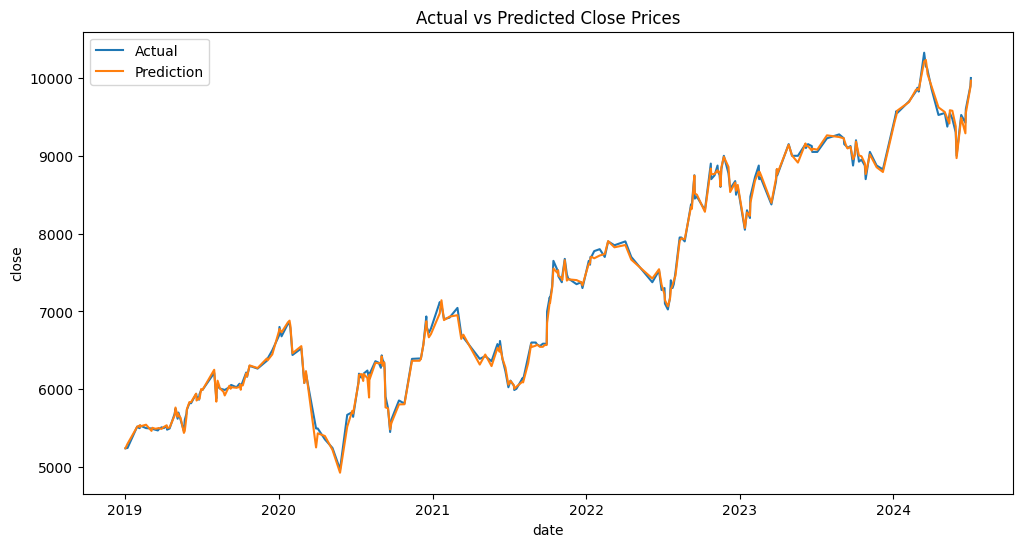

In [24]:
pandas_df = predictions.select("date", "close", "prediction").toPandas()
plt.figure(figsize=(12, 6))
sns.lineplot(x="date", y="close", data=pandas_df, label="Actual")
sns.lineplot(x="date", y="prediction", data=pandas_df, label="Prediction")
plt.title("Actual vs Predicted Close Prices")
plt.show()